# Datamining
## Assignment 1 - Exercise 5
<br></br>
<font size="4">

In General: We want to see if conspiracy theories are on the rise during the covid era, if their rise is connected to the number of cases/victims and each countrys' GDP. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pytrends.request import TrendReq

In [2]:
from pycountry_convert import country_alpha3_to_country_alpha2 as pc

Load owid covid data and keep only the global data as first we will examine the rise of conspiracies on a global level. 

In [3]:
dfCovid = pd.read_csv('owid-covid-data.csv')

dfCopy = dfCovid

dfCovid = dfCovid.loc[dfCovid['location'] == "World"]

dfCovid['death_rate'] = dfCovid['total_deaths']/dfCovid['total_cases']
dfCovid = dfCovid[['date','total_cases','new_cases','total_deaths','new_deaths','total_cases_per_million', 'total_deaths_per_million','death_rate']]
dfCovid

,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,total_deaths_per_million,death_rate
58893,2019-12-31,27.0,27.0,NaN,0.0,0.003,NaN,NaN
58894,2020-01-01,27.0,0.0,NaN,0.0,0.003,NaN,NaN
58895,2020-01-02,27.0,0.0,NaN,0.0,0.003,NaN,NaN
58896,2020-01-03,44.0,17.0,NaN,0.0,0.006,NaN,NaN
58897,2020-01-04,44.0,0.0,NaN,0.0,0.006,NaN,NaN
...,...,...,...,...,...,...,...,...
59221,2020-11-23,58806033.0,518752.0,1389592.0,7087.0,7544.266,178.272,0.023630
59222,2020-11-24,59338940.0,532907.0,1398568.0,8976.0,7612.633,179.423,0.023569
59223,2020-11-25,59900689.0,561749.0,1410737.0,12169.0,7684.700,180.984,0.023551
59224,2020-11-26,60547629.0,646940.0,1423289.0,12552.0,7767.696,182.595,0.023507


First we will examine some well known conspiracy theories, see their popularity and examine if it has risen during the covid period with data extracted from Google Trends.
Please note that these people may not be involved in any way, but are just mentioned as they are well known in the conspiracy-theory cycles.

We make len(kw_list) different queries because we don't want Google Trends to normalize the data similarly to the largest search volume, as we only want to see the increase/decrease of the popularity of each keyword.

In [4]:
# Create a Google Trend Object
# Data is normalized to the search with the largest search volume
totalTrend = TrendReq(hl='en-US', tz=360)

# Declare a var to store the search term
#### build the playload
#freemasons
kw_list = [["soros"],["new world order"],["5G dangers"],["population control"],["microchip vaccine"]]
_cat = 0
_geo = ''
_gprop = ''

# Build payload request to get data from Google trends
_timeframe = '2015-11-27 2020-11-27'

totalTrends = []
for i in kw_list:
    totalTrend = TrendReq(hl='en-US', tz=360)

    totalTrend.build_payload(i, cat=_cat, timeframe=_timeframe, geo=_geo, gprop=_gprop)

    # Get interest over time
    # Capture Monthly Data for use in Normalization against Weekly
    totalTrends.append(totalTrend.interest_over_time())

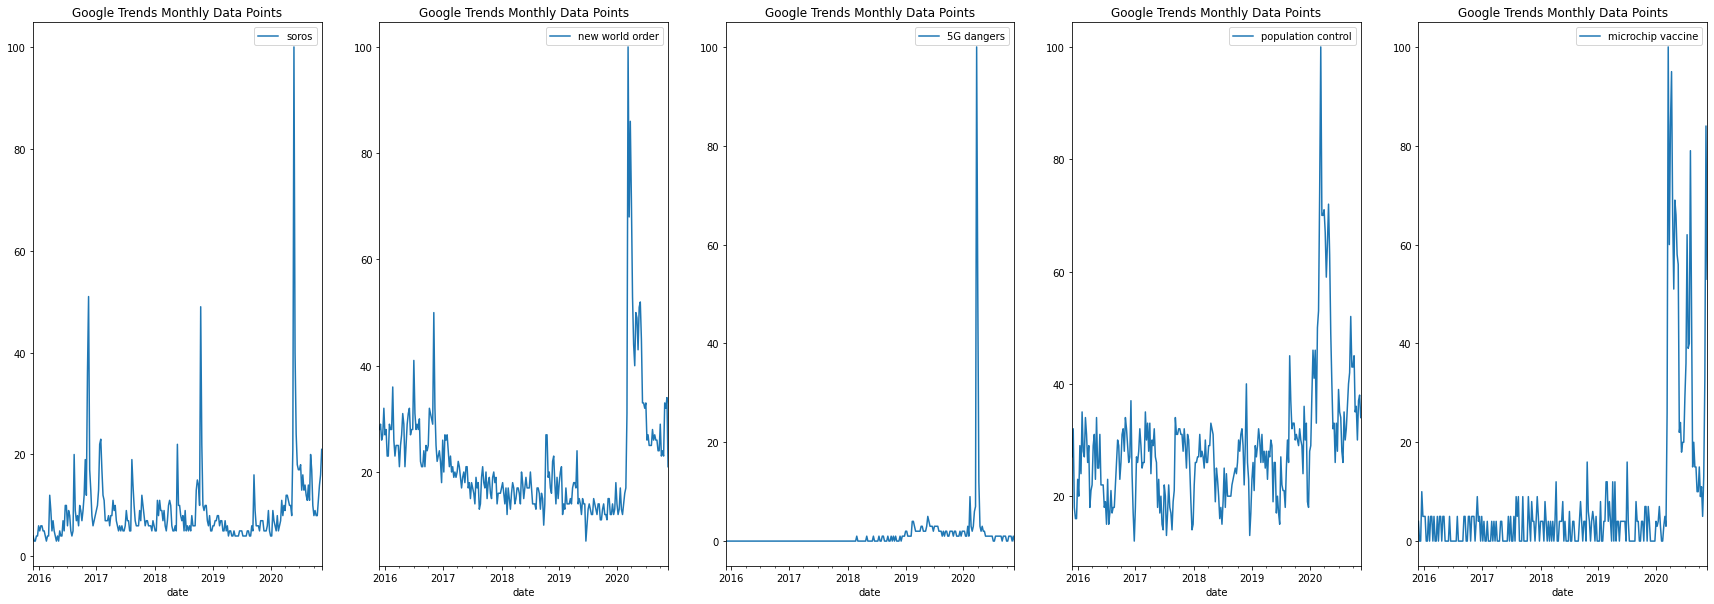

In [5]:
f, axes = plt.subplots(1, len(kw_list))
for i in range(len(kw_list)):
    totalTrends[i].plot(title='Google Trends Monthly Data Points', figsize=(30,10),ax = axes[i])

f.show()

On average the pandemic lockdowns started around 20 March 2020 (Q1 2020 in the graphs).
Source: https://en.wikipedia.org/wiki/COVID-19_pandemic_lockdowns 

Let's say that covid period lasts 1 year. We want to find the yearly mean popularity of each conspirancy theory and check if it has risen during the pandemic.

In [6]:
#date is end of month
monthlyTrends = []
for trends in totalTrends:
    monthlyTrends.append(trends.groupby(pd.Grouper(freq='1M')).mean())

Prepare data and calculate the mean yearly (12 months) values of each Google Trends query.

In [7]:
trendsYearly = []
for k in range(len(monthlyTrends)): 
    monthlyTrends[k].iloc[1]
    monthlyValues = []
    for i in range(len(monthlyTrends[k])):
        monthlyValues.append(np.array(list(monthlyTrends[k].iloc[i])))

    yearlyAvg = []
    for i in range(5):
        year = np.full((1, 2), 0.0)
        for j in range(12):
            year += monthlyValues[i*12+j]
            
        year = year/12
        yearlyAvg.append(year)
    monthlyValues = []
    for i in range(5):
        monthlyValues.append(list(yearlyAvg[i][0])[0]) 

    trendsYearly.append(pd.DataFrame(monthlyValues,columns=[monthlyTrends[k].columns[0]],
                    index=['2015-2016','2016-2017','2017-2018','2018-2019','2019-2020']))

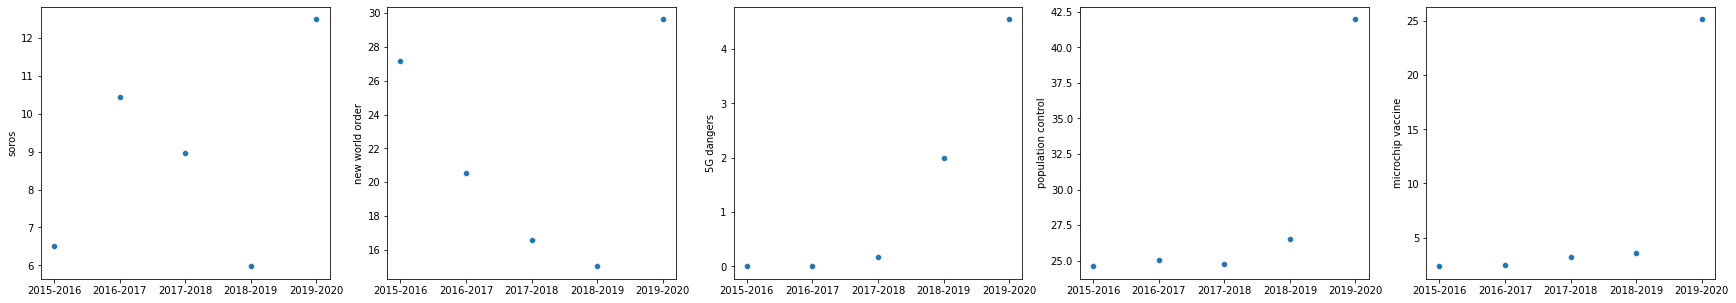

In [8]:
#plot the yearly means
f, axes = plt.subplots(1, len(kw_list))
f.set_figheight(5)
f.set_figwidth(30)
for i in range(len(trendsYearly)):
    sns.scatterplot(x=list(trendsYearly[i].index),y=trendsYearly[i].columns[0], data = trendsYearly[i],ax = axes[i])

Using the yearly mean values we can see that there is a rise in popularity of during the years 2019-2020.
From the monthly plots we can see (not that clearly, will change later if time allows it) that the maximum rise is during the beginning of the 1st global lockdown. At least visually we can assume that there is indeed a rise of popularity of conspiracy theories during the pandemic.

All conspiracy theories existed before the beginning of the Covid-19 pandemic.

Remove extra info and make both dataframes contain the same date.

In [9]:
dfCovidNewCases = pd.DataFrame(list(dfCovid['new_cases']),columns=['new_cases'],
                    index=dfCovid['date'])
dfCovidNewCases.index = pd.to_datetime(dfCovidNewCases.index)

dfCovidNewCases = dfCovidNewCases.groupby(pd.Grouper(freq='1W')).mean()
dfCovidNewCases.head()

,new_cases
date,
2020-01-05,9.833333
2020-01-12,0.000000
2020-01-19,23.000000
2020-01-26,257.714286
2020-02-02,1790.142857


In [10]:
for i in range(len(totalTrends)):
    mask = (totalTrends[i].index >= '2020-01-05')
    totalTrends[i] = totalTrends[i].loc[mask]
    del totalTrends[i]['isPartial']

In [11]:
dfCovidNewCases.drop(dfCovidNewCases.tail(1).index,inplace=True) # drop last n rows

Calculate correlation and p-value

In [12]:
for i in range(len(totalTrends)):
    tut = stats.pearsonr(dfCovidNewCases['new_cases'], totalTrends[i][totalTrends[i].columns[0]])
    print(totalTrends[i].columns[0])
    print("         " + str(tut))
    print("-"*60)

soros
         (0.0769887794621878, 0.6070000681198973)
------------------------------------------------------------
new world order
         (-0.18704570757780425, 0.20805326872306343)
------------------------------------------------------------
5G dangers
         (-0.20770867700460552, 0.16122390578381413)
------------------------------------------------------------
population control
         (-0.41024491264114415, 0.004183054443088195)
------------------------------------------------------------
microchip vaccine
         (0.08246611035785484, 0.581581940659679)
------------------------------------------------------------


As we can see, while we know that there is a rise of popularity during the pandemic, it isn't really correlated with the rate of weekly covid cases.

Let's examine the correlation up to the middle of 1st lockdown (average date), 2020-03-30, and see if anything changes.

In [13]:
for i in range(len(totalTrends)):
    mask = (totalTrends[i].index <= '2020-03-30')
    totalTrends[i] = totalTrends[i].loc[mask]

In [14]:
mask = (dfCovidNewCases.index <= '2020-03-30')
dfCovidNewCases = dfCovidNewCases.loc[mask]

In [15]:
for i in range(len(totalTrends)):
    tut = stats.pearsonr(dfCovidNewCases['new_cases'], totalTrends[i][totalTrends[i].columns[0]])
    print(totalTrends[i].columns[0])
    print("         " + str(tut))
    print("-"*60)

soros
         (0.5358415042740347, 0.059099270215444186)
------------------------------------------------------------
new world order
         (0.7170649405516993, 0.0058039617752067806)
------------------------------------------------------------
5G dangers
         (0.9283298701290048, 4.691560724114713e-06)
------------------------------------------------------------
population control
         (0.44181332469163104, 0.13065462754590604)
------------------------------------------------------------
microchip vaccine
         (0.75743806749597, 0.00271061747015502)
------------------------------------------------------------


Up until the first lockdown (popularity rise spike) we can see that 3/5 are of statistical importance, while all (5/5) of our queries are, some more some less, correlated.

We believe that this happens because people were stressed due to the first-seen (then) pandemic,self-isolation,war-like situation and sought a way to distract themselves and escape from reality. 

We also believe that this spike only happens one time because as time passed, people got used of the overall situation and only the true conspirancy theorists remained.

Now, we will try to get the mean popularity during the pandemic in some countries and see how it correlates with the country GDP.

Convert to alpha2 iso codes for use in pytrends.

In [16]:
dfCopy = dfCopy[['date','iso_code','location','new_cases','gdp_per_capita']]

In [17]:
iso_codes_alpha2 = pd.unique(dfCopy['iso_code'])
#iso_codes_alpha3
iso_codes_alpha2 = iso_codes_alpha2[iso_codes_alpha2!='OWID_WRL']
iso_codes_alpha2 = iso_codes_alpha2[iso_codes_alpha2!='OWID_KOS']
iso_codes_alpha2 = iso_codes_alpha2[:-1]


for i in range(len(iso_codes_alpha2)):
    iso_codes_alpha2[i] = pc(iso_codes_alpha2[i])

Pulling the trends for each country is SLOW! We will choose 9 bigger countries as some smaller countries simply don't have the search volume (and time!) required to display data. This can be modified to run for every country.

In [18]:
iso_chosen_countries = ['NG','IN','ID','MY','TR','BR','JP','FR','DE']
names_chosen_countries = ['Nigeria','India','Indonesia','Malaysia','Turkey','Brazil','Japan','France','Germany']
countryTrends = []
for iso in iso_chosen_countries:
    # Create a Google Trend Object
    # Data is normalized to the search with the largest search volume
    totalTrend = TrendReq(hl='en-US', tz=360)

    # Declare a var to store the search term
    kw_list = [["soros"],["new world order"],["5G dangers"],["population control"],["microchip vaccine"]]
    _cat = 0
    _geo = iso
    _gprop = ''

    # Build payload request to get data from Google trends
    _timeframe = '2019-11-27 2020-11-27'

    totalTrends = []
    for i in kw_list:
        totalTrend = TrendReq(hl='en-US', tz=360)

        totalTrend.build_payload(i, cat=_cat, timeframe=_timeframe, geo=_geo, gprop=_gprop)

        # Get interest over time
        # Capture Monthly Data for use in Normalization against Weekly
        totalTrends.append(totalTrend.interest_over_time())
    countryTrends.append(totalTrends)

In [19]:
for i in range(len(countryTrends)):
    for j in range(len(countryTrends[i])):
        countryTrends[i][j] = countryTrends[i][j].mean()

In [20]:
gdp_chosen_countries = []
for name in names_chosen_countries:
    gdppc = list(dfCopy.loc[dfCopy['location'] == name]['gdp_per_capita'])[0]
    gdp_chosen_countries.append(gdppc)

In [21]:
for i in range(len(countryTrends)):
    tempTrend = []
    for j in range(len(countryTrends[i])):
        t = list(countryTrends[i][j])
        if(len(t)>1):
            tempTrend.append(t[0])
        else:
            tempTrend.append(np.nan)
    countryTrends[i] = tempTrend

Not all countries have data for every search term.

In [22]:
conspiracyAllCountries = [[] for j in range(len(kw_list))]

for ct in countryTrends:
    for i in range(len(ct)):
        conspiracyAllCountries[i].append(ct[i])

for i in range(len(conspiracyAllCountries)):
    mask1 = np.ma.array(conspiracyAllCountries[i], mask=np.isnan(conspiracyAllCountries[i])) # Use a mask to mark the NaNs
    mask2 = np.ma.array(gdp_chosen_countries, mask=np.isnan(conspiracyAllCountries[i])) # Use a mask to mark the NaNs
    mask1 = mask1[~mask1.mask]
    mask2 = mask2[~mask2.mask]

    if(len(mask1) > 2):
        tut = stats.pearsonr(mask1, mask2)
        print(kw_list[i])
        print("         " + str(tut))
        print("-"*60)

['soros']
         (0.17006834886499078, 0.6617819245722316)
------------------------------------------------------------
['new world order']
         (0.24729315622540465, 0.5211906819188104)
------------------------------------------------------------
['5G dangers']
         (0.3885048925177519, 0.5180820109250023)
------------------------------------------------------------
['population control']
         (-0.2712985921486275, 0.48010152314225546)
------------------------------------------------------------


From the above results we can see that GDP per capita isn't correlated with the popularity of conspiracy theories.

We assume that this means that there are people who believe in them in every country, regardless GDPPC.
(or we have a very small sample)

<h2> Γενικές Παρατηρήσεις:

Οι συγκεκριμένες θεωρίες συνωμοσίας υπήρχαν και πριν την αρχή της πανδημίας.

Εξετάσαμε τη περίοδο 2015-2020 για τη δημοτικότητα των θεωριών συνωμοσίας, παραπάνω είδαμε ότι υπάρχει μια γενική αύξηση της δημοτικότητας (στο Google Trends) παγκοσμίως κατά τη πανδημία (2019-2020) σε σχέση με τις άλλες χρονιές.

Ειδικότερα εξετάσαμε παγκόσμια κατα τη περίοδο της πανδημίας:
<li> Αν η δημοτικότητα σχετίζεται με τα νέα κρούσματα (εβδομαδιαία), πράγμα που σε ολόκληρο το έτος είδαμε οτι δεν ισχύει. 
<li> Είδαμε όμως ότι αυτό ισχύει μέχρι τη μέση ημερομηνία αρχής του 1ου lockdown, και ίσως λίγο αργότερα, (παγκόσμια) πράγμα που εξηγήσαμε ότι λογικά οφείλεται στην αύξηση του στρες λόγω των πρωτόγνωρων συνθηκών και ημερήσια αύξηση των κρουσμάτων. Έτσι, πιστεύουμε ότι οι άνθρωποι στράφηκαν στις θεωρίες συνομοσίας κατα τη περίοδο αυτή για να ξεφύγουν απο τη δύσκολη πραγματικότητα. Μέτα την περιοδο αυτή, έχοντας πια συνηθίσει τις νέες συνθήκες πιστεύουμε πως πια ψάχναν για θεωρίες συνομοσίας σταδιακά και λιγότεροι άνθρωποι, μέχρι να παραμείνουν αυτοί που τις πιστεύαν ούτως ή άλλως, γι'αυτό υπάρχει και η σχετική πτώση. Οι μετρήσεις έγιναν με τη χρήση του Pearson correlation coefficient και είδαμε ότι είχαμε και αρκέτες τιμές με κατάλληλο p-value.
<li> Τέλος, εξετάσαμε 9 χώρες (μπορεί να γενικευτεί για όλες, δεν έγινε λόγω χρόνου), βρήκαμε το μέσο όρο δημοτικότητας της κάθε μίας θεωρίας στη περιόδο της πανδημίας και είδαμε (γενικά για όλες τις χώρες) αν αυτές σχετίζονται με το GDP per capita της κάθε χώρας. Βρήκαμε ότι αυτό δεν ισχύει, δηλαδή ότι δεν σχετίζονται, πράγμα που ερμηνεύουμε πως η αγοραστική δύναμη πολίτη (gdp per capita) δεν έχει σχέση με τη αύξηση αυτή.